# New Section

In [ ]:
#Do not run
#Format of input?
#2D input array into keras
#!pip install --target=$nb_path moabb
#!pip3 install --target=$nb_path torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install --target=$nb_path braindecode
#!pip install --target=$nb_path mne
#!pip install --target=$nb_path -U https://api.github.com/repos/braindecode/braindecode/zipball/master
#!pip install --target=$nb_path git+https://github.com/forrestbao/pyeeg.git
#!pip install eeglib

!pip3 install numba==0.48.0

In [ ]:

import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)


#4/1AX4XfWhv3cBxSin7WYEfMUa4vnyi5O4Cx-MYYR-hW-PeCAYZQBj7CH1b248

Mounted at /content/drive


In [ ]:
import io
from google.colab import files
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

def integers(a, b):
         return list(range(a, b+1))

#config
OutputType = "Infrared to Red Signal Ratio"
ReadyInput = r"/content/drive/My Drive/raw_braindecode_infrared/data.csv"
InputDir = "/content/drive/My Drive/raw_braindecode_infrared"
min_delta = 60*1
delta_threshold = min_delta
n_times_input = 256*45
rawlist = integers(1,12)
mainpath = "/content/drive/My Drive/RawEEG_M5/"
#end config

sys.path.insert(0,nb_path)

import cv2
from PIL import Image
from numpy import asarray
import matplotlib
import pathlib
import mne
import scipy

import pyeeg
import eeglib
import random
from scipy import linalg
import scipy.stats
from mne.preprocessing import ICA

In [ ]:
filexist = False
#savefile = pd.read_csv(ReadyInput,header = 0,index_col = 0)
#filexist = True
!rm -rf "/content/drive/My Drive/raw_braindecode_infrared"
!mkdir "/content/drive/My Drive/raw_braindecode_infrared"

for i in rawlist:

  order = str(i)+"/"
  subpath = os.path.join(mainpath,order)

  ################################################
  output_fname = OutputType+".xlsx"
  data_file = os.path.join(subpath, output_fname )
  dump = pd.ExcelFile(data_file)
  HeartRate = dump.parse(OutputType)

  OutputData = pd.DataFrame(HeartRate[OutputType])
  if (HeartRate["TimeStamp"].size < 1):
    continue
  #################################################
  obci_fname = 'raw.txt'
  data_file = os.path.join(subpath, obci_fname )

  channel_names = ['Fp1', 'Fp2', 'C3', 'C4', 'T5', 'T6', 'O1','O2']
  channel_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg','eeg']
  sfreq = 250  # in Hertz
  montage = 'standard_1020'

  info = mne.create_info(channel_names, sfreq, channel_types)

  n_channels = 8
  sampling_rate = 250
  #info = mne.create_info(n_channels, sampling_rate)
  print(info)

  counter = 0
  window_ = 5
  jumpstep_ = 3
  InputData = []
  OutputData = {}
  queue = {}
  sum_ = {}
  data_arr = np.empty((0, 8))
  time = 0
  timein = 0
  eeg_id = ["1","2","3","4","5","6","7","8"]
  dummy = np.empty((1, 8))
  id = np.zeros((340,1))
  inlen = 0



  _Tau = 2 #in fisher_info
  _DE = 20 #in fisher_info
  _Band = [0.5,4,7,12,30] #bin_power
  _Freq = 250
  _M  = 2  #ap_en and sa_en 
  #_R =  std(time_series)/4    for ap_en and sa_en

  sphere_not_define = True
  def createList(n):
      lst = []
      for i in range(n+1):
          lst.append(i)
      return(lst)
  newraw = np.empty((9, 10000000))
  newraw_l = 0
  with open( data_file, 'r' ) as in_f:
      header = True
      while header:
          line = next( in_f )
          if line[0] != '%':
              header = False
      dump = True
      for line in in_f:
          temp = np.array(line.strip( ' \n' ).split( ', ' )[1:23]).astype(np.float)
          newraw[0][newraw_l] = temp[0]
          newraw[1][newraw_l]  = temp[1]
          newraw[2][newraw_l]  = temp[2]
          newraw[3][newraw_l]  = temp[3]
          newraw[4][newraw_l]  = temp[4]
          newraw[5][newraw_l]  = temp[5]
          newraw[6][newraw_l]  = temp[6]
          newraw[7][newraw_l]  = temp[7]
          newraw[8][newraw_l]  = temp[21]
          newraw_l += 1

      newraw = mne.filter.filter_data(newraw[:,0:newraw_l], sfreq, 0.5, 70, picks=createList(7))
      newraw = mne.filter.notch_filter(newraw, sfreq, 50, picks=createList(7))
              
      time_arr = newraw[8]
      
      custom_raw = mne.io.RawArray(newraw[0:8,0:newraw_l], info)
      custom_raw.set_montage('standard_1020')

      ica = ICA(n_components=8, max_iter='auto', random_state=123)
      ica.fit(custom_raw)
      ica.apply(custom_raw)

      if (sphere_not_define):
                sphere = mne.make_sphere_model('auto', 'auto', custom_raw.info)
                src = mne.setup_volume_source_space(sphere=sphere, exclude=30., pos=15.)
                forward = mne.make_forward_solution(custom_raw.info, trans=None, src=src, bem=sphere)
                sphere_not_define = False

      custom_raw.set_eeg_reference(ref_channels='REST',forward=forward)

      newraw = np.vstack((custom_raw._data,time_arr[np.newaxis,:]))

      del custom_raw

      for temp in range(newraw_l):
          #np.vstack((data_arr,np.array( line.strip( ' \n' ).split( ', ' )[1:9] )))
          #np.insert(X, 0, 6., axis=0)
          if (dump):
              dump = False
          else:
              #temp = np.array(line.strip( ' \n' ).split( ', ' )[1:23]).astype( np.float )
              time = newraw[8][temp] 
          if (time < HeartRate["TimeStamp"][timein]):
              continue
          if (time > (HeartRate["TimeStamp"][timein]+delta_threshold)):
              counter = 0
              timein += 1      
              data_arr = np.empty((0, 8))
              continue
          counter = counter + 1
          for x in range(8):
            dummy[:,x] = newraw[x][temp]
          data_arr = np.vstack((data_arr,dummy))
            
          if (counter == n_times_input):
              data_arr = data_arr.T
              
              #for y in range(4*256):
              #    data_arr[:,y] = data_arr[:,y] - mean(data_arr[:,y])
              
              #data_arr = data_arr - mean(data_arr, 1)

              target = HeartRate[OutputType][timein]

              datasets = []
              #save_concat_dataset("/content/drive/My Drive/raw_braindecode", windows_dataset)

              #custom_raw.filter(0.5, 70)
              #custom_raw.notch_filter(60)
              
            

              raw_ = data_arr
              print(raw_.shape)
              #custom_raw.set_eeg_reference(ref_channels='average')

              #custom_raw.resample(60)

              data_arr = np.empty((0, 8))
              frame = np.empty((0))
              for X in raw_:

                  std = np.std(X)
                  mean = np.mean(X)
                  #fft = np.fft.fft(X)

                  skew = scipy.stats.skew(X, axis=0, bias=True)
                  kurtosis = scipy.stats.kurtosis(X, axis=0, fisher=True, bias=True)

                  R = std/4                
                  ap_en = pyeeg.ap_entropy(X,_M,R)
                  sa_en = pyeeg.samp_entropy(X,_M,R)
                  D = np.diff(X).tolist()
                  M = pyeeg.embed_seq(X,_Tau,_DE)
                  W = linalg.svd(M, compute_uv=0)
                  W /= sum(W)
                  bin = pyeeg.bin_power(X,_Band,_Freq)
                  df = pyeeg.dfa(X)
                  hj = pyeeg.hjorth(X,D=D)
                  hu = pyeeg.hurst(X)
                  pf = pyeeg.pfd(X,D=D)
                  sv_en = pyeeg.svd_entropy(X,_Tau,_DE,W=W)
                  fi = pyeeg.fisher_info(X,_Tau,_DE,W=W)
                  sp_en = pyeeg.spectral_entropy(X,_Band,_Freq, Power_Ratio=bin)

                  hf = eeglib.features.HFD(X)
                  lz = eeglib.features.LZC(X)
                  SigC = eeglib.features.countSignChanges(X)
                  ha = eeglib.features.hjorthActivity(X)

                  #bin 2D
                  #hj 1D
                  #sp_en 1D

                  """
                  List of features extracted:

                  Standard deviation
                  Mean
                  Skewness
                  Kurtosis
                  Detrended Fluctuation Analysis
                  Hurst exponent
                  Petrosian Fractal Dimension
                  SVD Entropy
                  Fisher information
                  Lempel-Ziv Complexity (LZ76)
                  number of sign changes
                  Higuchi Fractal Dimension 
                  Approximate entropy
                  Sample entropy
                  Hjorth Activity
                  Hjorth mobility
                  Hjorth complexity
                  Spectral entropy of each band in 4 bands
                  Normalized spectral power of each band in 4 bands
                  (FFT and spectrogram are not included directly due to size but spectral information is included)
                  """
                  temp1 = np.array([std,mean,skew,kurtosis,df,hu,pf,sv_en,fi,lz,SigC,hf,ap_en,sa_en,ha])

                  bin = np.asarray(bin).flatten()
                  temp2 = np.concatenate((np.asarray(hj),np.asarray(sp_en)))
                  temp2 = np.concatenate((temp2,bin[4:8]))
                  temp = np.concatenate((temp1,temp2))
                  frame = np.concatenate((frame,temp))

              frame = np.concatenate((frame,np.array([target])))
              '''status = random.randint(1, 10)
              
              if (status < 9 ):
                f_descrition = pd.Series(
                  data=[target, "train"],
                  index=["target", "session"])
              else:
                f_descrition = pd.Series(
                  data=[target, "test"],
                  index=["target", "session"])
              base_ds = BaseDataset(custom_raw, f_descrition, target_name="target")
              datasets.append(base_ds)
              InputData = BaseConcatDataset(datasets)'''
              if (filexist):
                savefile = pd.concat([savefile, pd.DataFrame(frame)], axis=1)
                #savefile.append(pd.DataFrame(frame))
                print(savefile.shape)
              else: 
                savefile = pd.DataFrame(frame)
                filexist = True
              timein += 1
              if (timein >= HeartRate[OutputType].size):
                break
              data_arr = np.empty((0, 8))
              counter = 0
savefile.to_csv(ReadyInput)

  #apply Z score later in preprocessing before training




<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, C3, C4, T5, T6, O1, O2
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>
Setting up band-pass filter from 0.5 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 1651 samples (6.604 sec)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stop

<ipython-input-4-3b21928eeae1>:96: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(custom_raw)


Selecting by number: 8 components
Fitting ICA took 28.7s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Fitted sphere radius:         96.4 mm
Origin head coordinates:      0.3 9.5 35.1 mm
Origin device coordinates:    0.3 9.5 35.1 mm

Equiv. model fitting -> RV = 0.0034856 %
mu1 = 0.944754    lambda1 = 0.137089
mu2 = 0.667504    lambda2 = 0.683819
mu3 = -0.26966    lambda3 = -0.0105378
Set up EEG sphere model with scalp radius    96.4 mm

Sphere                : origin at (0.3 9.5 35.1) mm
              radius  : 86.7 mm
grid                  : 15.0 mm
mindist               : 5.0 mm
Exclude               : 30.0 mm

Setting up the sphere...
Surface CM = (   0.3    9.5   35.1) mm
Surface fits inside a sphere with radius   86.7 mm
Surface extent:
    x =  -86.4 ...   87.0 mm
    y =  -77.2 ...   96.2 mm
    z =  -51.6 ...  121.8 mm
Grid extent:
    x =  -90.0 ...   90.0 mm
    y =  -90.

<ipython-input-4-3b21928eeae1>:100: RuntimeWarning: Only 8 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  sphere = mne.make_sphere_model('auto', 'auto', custom_raw.info)



Finished.
EEG channel type selected for re-referencing
Applying REST reference.
Applying a custom ('EEG',) reference.
    8 out of 8 channels remain after picking
(8, 11520)


/content/notebooks/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/content/notebooks/pyeeg/detrended_fluctuation_analysis.py:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ).T, numpy.log(F))[0][0]
/content/notebooks/pyeeg/hurst.py:54: RuntimeWarning: invalid value encountered in true_divide
  R_S = R_T / S_T
/content/notebooks/pyeeg/hurst.py:58: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max

(8, 11520)


In [ ]:
savefile.to_csv(ReadyInput)

NameError: ignored

In [ ]:
print(savefile)

     Unnamed: 0  Unnamed: 0.1  ...      0.231.1      0.232.1
0             0             0  ...  1170.002770  1211.430728
1             1             1  ...   124.088615  -203.799907
2             2             2  ...     0.683249     0.004192
3             3             3  ...     0.822285     0.176436
4             4             4  ...     1.243426     1.999705
..          ...           ...  ...          ...          ...
196         196           196  ...     0.537048     0.511542
197         197           197  ...     0.129437     0.124680
198         198           198  ...     0.191255     0.158313
199         199           199  ...     0.142259     0.205465
200         200           200  ...    51.000000    52.000000

[201 rows x 849 columns]


     Unnamed: 0.1  Unnamed: 0.1.1  ...      0.485.1      0.486.1
0               0               0  ...  1560.177760  2178.349880
1               1               1  ...   -18.186513    90.700404
2               2               2  ...     0.032373    -0.443186
3               3               3  ...     5.614611    12.900503
4               4               4  ...     0.582764     0.334239
..            ...             ...  ...          ...          ...
196           196             196  ...     0.192055     0.234704
197           197             197  ...     0.113229     0.108310
198           198             198  ...     0.147817     0.141712
199           199             199  ...     0.546899     0.515274
200           200             200  ...    51.000000    49.000000

[201 rows x 2131 columns]
(2131, 200)
(2131,)
.


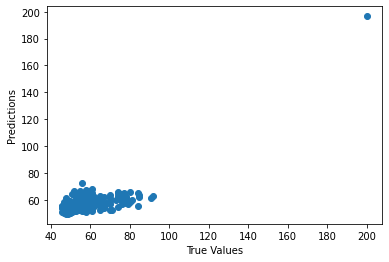

RandomForestRegressor(n_estimators=750, random_state=333)
0.5840531995962195


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.tree import export_graphviz 
from sklearn.metrics import mean_squared_error
import graphviz 
import operator
import math



savefile = pd.read_csv(ReadyInput,header = 0,index_col = 0)
#savefile = savefile.drop(savefile.columns[[0]], inplace=True, axis = 1)
print(savefile)

SourceData_train_independent = savefile.drop(200).T
print(SourceData_train_independent.shape)
SourceData_train_dependent= savefile.iloc[200]
print(SourceData_train_dependent.shape)

sc_X = StandardScaler()

y_train=SourceData_train_dependent 
X_train= SourceData_train_independent

#X_train=sc_X.fit_transform(X_train.values) 

X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,train_size = 0.8, test_size=0.2, random_state = 444)
reg = RandomForestRegressor(max_depth=None, random_state=333, n_estimators=750).fit(X_train, y_train)
    
predictions = reg.predict(X_test)
plt.scatter(y_test,predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
print(".")
plt.show()
print(reg)
importances = reg.feature_importances_
print(r2_score(y_test,predictions))